## COVID-19 research articles: Text Analytics using NLP

In [1]:
# Importing the libraries
import pandas as pd
pd.options.display.max_colwidth = 100
import regex as re
from nltk.stem import WordNetLemmatizer
import nltk
from nltk import word_tokenize
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
import collections
from nltk.util import ngrams   
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from heapq import nlargest
import en_core_web_lg
nlp = en_core_web_lg.load()
nlp.max_length = 1800000 
import glob
import json

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\welcome\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\welcome\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\welcome\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Metadata contains a number of columns related to the papers
metaDF = pd.read_csv('CORD-19-research-challenge/metadata.csv', usecols = ['title','abstract','authors'])

# Papers are in the form of json files saved under different folders
json_files = glob.glob('CORD-19-research-challenge/**/*.json', recursive=True)
len(json_files)

29315

In [3]:
class FileReader:
    def __init__(self, file_path):
        with open(file_path) as file:
            content = json.load(file)
            self.paper_id = content['paper_id']
            self.abstract = []
            self.body_text = []
            # Abstract
            for entry in content['abstract']:
                self.abstract.append(entry['text'])
            # Body text
            for entry in content['body_text']:
                self.body_text.append(entry['text'])
            # Adding in list    
            self.abstract = '\n'.join(self.abstract)
            self.body_text = '\n'.join(self.body_text)

In [4]:
# Creating a pandas dataframe for papers

paper_dict = {'paper_id': [], 'abstract': [], 'body_text': []}

for i, entry in enumerate(json_files):
    # For viewing the progress
    if i % (len(json_files) // 10) == 0:
        print(f'Processing index: {i} of {len(json_files)}')
    # Loading content of json files
    content = FileReader(entry)
    paper_dict['paper_id'].append(content.paper_id)
    paper_dict['abstract'].append(content.abstract)
    paper_dict['body_text'].append(content.body_text)
    
papers = pd.DataFrame(paper_dict, columns=['paper_id', 'abstract', 'body_text'])
papers = pd.merge(papers, metaDF, how = 'left')

Processing index: 0 of 29315
Processing index: 2931 of 29315
Processing index: 5862 of 29315
Processing index: 8793 of 29315
Processing index: 11724 of 29315
Processing index: 14655 of 29315
Processing index: 17586 of 29315
Processing index: 20517 of 29315
Processing index: 23448 of 29315
Processing index: 26379 of 29315
Processing index: 29310 of 29315


In [5]:
papers.head(10)

,paper_id,abstract,body_text,title,authors
0,0015023cc06b5362d332b3baf348d11567ca2fbb,word count: 194 22 Text word count: 5168 23 24 25 author/funder. All rights reserved. No reuse a...,"VP3, and VP0 (which is further processed to VP2 and VP4 during virus assembly) (6). The P2 64 an...",NaN,NaN
1,004f0f8bb66cf446678dc13cf2701feec4f36d76,,"The 2019-nCoV epidemic has spread across China and 24 other countries 1-3 as of February 8, 2020...",NaN,NaN
2,00d16927588fb04d4be0e6b269fc02f0d3c2aa7b,Infectious bronchitis (IB) causes significant economic losses in the global poultry industry. Co...,"Infectious bronchitis (IB), which is caused by infectious bronchitis virus (IBV), is one of the ...",NaN,NaN
3,0139ea4ca580af99b602c6435368e7fdbefacb03,"Nipah Virus (NiV) came into limelight recently due to an outbreak in Kerala, India. NiV causes s...",Nipah is an infectious negative-sense single-stranded RNA virus which belongs to the genus henip...,NaN,NaN
4,013d9d1cba8a54d5d3718c229b812d7cf91b6c89,"Background: A novel coronavirus (2019-nCoV) emerged in Wuhan City, China, at the end of 2019 and...","In December 2019, a cluster of patients with pneumonia of unknown cause were reported in the cit...",NaN,NaN
5,01d162d7fae6aaba8e6e60e563ef4c2fca7b0e18,"Faced with the current large-scale public health emergency, collecting, sorting, and analyzing b...",The sudden outbreak of the new coronavirus (SARS-CoV-2) at the end of December 2019 poses a huge...,NaN,NaN
6,01e3b313e78a352593be2ff64927192af66619b5,"Viruses interact with hundreds to thousands of proteins in mammals, yet adaptation 6 against vir...",The copyright holder for this preprint (which was not peer-reviewed) is the author/funder. It . ...,NaN,NaN
7,02201e4601ab0eb70b6c26480cf2bfeae2625193,School closure is often considered as an option to mitigate influenza epidemics because of its p...,"they affect seasonal influenza dynamics. The model is applied to Belgium, parameterized with cou...",NaN,NaN
8,0255ea4b2f26a51a3bfa3bd8f3e1978c82c976d5,Post-transcriptional gene silencing (PTGS) is a powerful tool to understand and control plant me...,"siRNA without relying on plant transformation, however, most viruses are limited in their host r...",NaN,NaN
9,029c1c588047f1d612a219ee15494d2d19ff7439,,"estimation is complicated, however, by efforts to isolate infected individuals in hospitals or 4...",NaN,NaN


In [6]:
# Deleting variables which won't be of use further
del metaDF
del json_files

In [7]:
# Function to filter papers containing specific words in abstract
def filter_papers(word_list):
    papers_id_list = []
    for i, row in papers.iterrows():
        if all(x in row.body_text.lower() for x in word_list):
            papers_id_list.append(row.paper_id)
    return papers_id_list

In [8]:
# Using only papers talking about coronavirus
covidPaperIDs = filter_papers(["coronavirus"])
print("\nNumber of papers containing 'coronavirus' = ", len(covidPaperIDs))
papers = papers.loc[papers['paper_id'].isin(covidPaperIDs)]


Number of papers containing 'coronavirus' =  16072


In [9]:
# Creating a new dataframe containing content to be processed with NLP
papersData = papers.loc[:,['paper_id', 'abstract', 'body_text']]
# Merging abstract and body text
papersData.abstract += '\n' + papersData.body_text
# Renaming the new column as content
papersData.drop('body_text', axis = 1, inplace = True)
papersData.rename(columns = {'abstract':'content'}, inplace = True)
papersData.head()

,paper_id,content
2,00d16927588fb04d4be0e6b269fc02f0d3c2aa7b,Infectious bronchitis (IB) causes significant economic losses in the global poultry industry. Co...
4,013d9d1cba8a54d5d3718c229b812d7cf91b6c89,"Background: A novel coronavirus (2019-nCoV) emerged in Wuhan City, China, at the end of 2019 and..."
5,01d162d7fae6aaba8e6e60e563ef4c2fca7b0e18,"Faced with the current large-scale public health emergency, collecting, sorting, and analyzing b..."
6,01e3b313e78a352593be2ff64927192af66619b5,"Viruses interact with hundreds to thousands of proteins in mammals, yet adaptation 6 against vir..."
10,03ce432f27c7df6af22b92245a614db2ecb5de5f,Human astroviruses are small nonenveloped viruses with positive-sense single-stranded RNA genome...


**Functions to clean text**

In [10]:
def remove_URL(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

In [11]:
punct =[]
punct += list(string.punctuation)
punct += '’'
punct.remove("'")
def remove_punctuations(text):
    for punctuation in punct:
        text = text.replace(punctuation, ' ')
    return text

In [12]:
STOPWORDS = set(stopwords.words('english'))
# Adding new stopwords which are not relevant
STOPWORDS |= set(['title','abstract','preprint','biorxiv','author','copyright','holder','https','license','et','al','may',
                  'also','medrxiv','granted','reuse','rights','used','reserved','peer','holder','figure','fig','table'])
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])


In [13]:
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

In [14]:
def clean_text(col):
    print('Converting to lower case...')
    papersData[col]= papersData[col].str.lower()
    print('Removing /n characters...')
    papersData[col]= papersData[col].apply(lambda x: x.replace('\n', ' '))
    print('Removing urls...')
    papersData[col]= papersData[col].apply(lambda text: remove_URL(text))
    print('Removing punctuations...')
    papersData[col]= papersData[col].apply(lambda text: remove_punctuations(text))
    print('Removing the stopwords...')
    papersData[col]= papersData[col].apply(lambda text: remove_stopwords(text))
    print('Lemmatization of text...')
    papersData[col]= papersData[col].apply(lambda text: lemmatize_words(text))
    print('Removing digits...')
    papersData[col]= papersData[col].map(lambda x: re.sub(r'\d+', '', x))
    
clean_text('content')

Converting to lower case...
Removing /n characters...
Removing urls...
Removing punctuations...
Removing the stopwords...
Lemmatization of text...
Removing digits...


### **Creating a word cloud**

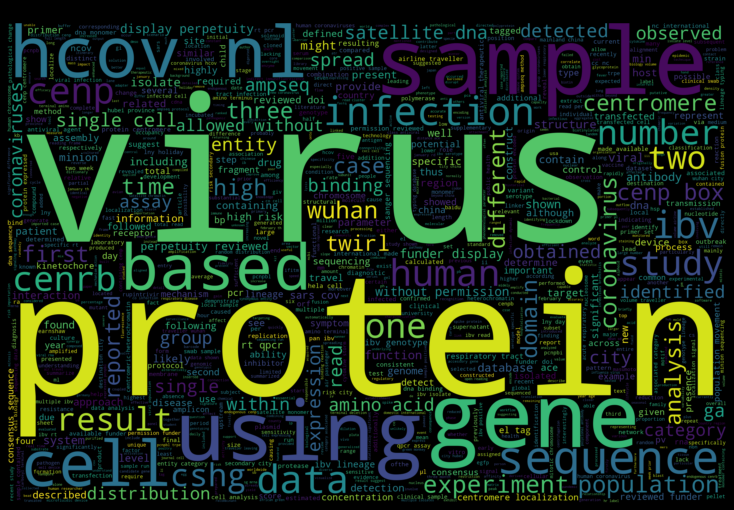

In [15]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
contentCorpus = papersData.content.values
wordcloud = WordCloud(width = 3000,
                      height = 2000,
                      background_color = 'black',
                      max_words=1000).generate(str(contentCorpus))
fig = plt.figure(figsize = (10, 10),
                 facecolor = 'k',
                 edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('Content Corpus')
plt.show()

**Extracting most common 3-word phrases**

In [16]:
# Tokenizing the entire abstracts available in all papers
all_text = ' '.join(str(word) for word in papersData.content.values) 
tokens = word_tokenize(all_text)

# Listing most common n-grams 
ng3 = ngrams(tokens, 3)
ng3 = collections.Counter(ng3)
ng3.most_common(20)

[(('severe', 'acute', 'respiratory'), 7354),
 (('acute', 'respiratory', 'syndrome'), 6927),
 (('real', 'time', 'pcr'), 5868),
 (('respiratory', 'tract', 'infection'), 5715),
 (('respiratory', 'syncytial', 'virus'), 5424),
 (('according', 'manufacturer', "'s"), 4904),
 (('mers', 'cov', 'infection'), 4746),
 (('lower', 'respiratory', 'tract'), 4553),
 (('play', 'important', 'role'), 4533),
 (('polymerase', 'chain', 'reaction'), 4515),
 (('manufacturer', "'s", 'instruction'), 4432),
 (('amino', 'acid', 'sequence'), 4403),
 (('respiratory', 'syndrome', 'coronavirus'), 4355),
 (('upper', 'respiratory', 'tract'), 3956),
 (('sars', 'cov', 'infection'), 3705),
 (('innate', 'immune', 'response'), 3665),
 (('respiratory', 'syndrome', 'sars'), 3552),
 (('east', 'respiratory', 'syndrome'), 3530),
 (('middle', 'east', 'respiratory'), 3526),
 (('real', 'time', 'rt'), 3400)]

### Extracting summarized text of papers related to particular search-words

In [17]:
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer(analyzer='word', stop_words = 'english', sublinear_tf=True)
    matrix = tfidf_vectorizer.fit_transform(data)
    return matrix, tfidf_vectorizer

def sentence_score(sentence: str, word_scores: dict):
    words = sentence.split()
    if len(words) < 50:
        score = sum([word_scores.get(w.lower(),0) for w in words])
    else:
        score=0
    return score

def occurrences(text, word): 
    ctr = 0
    tokens = text.split(" ") 
    for i in range(len(tokens)): 
        if (word == tokens[i].lower()): 
           ctr += 1
    return ctr  


def summarize(paper_id):
    papertext = papers[papers.paper_id == paper_id].body_text
    list_corpus = list(papertext)
    tfidf_matrix, tfidf_vectorizer = tfidf(list_corpus)
    
    # Creating a dataframe with the words scores
    word_scores_df = pd.DataFrame(tfidf_matrix.toarray(), columns = tfidf_vectorizer.get_feature_names())   
    word_scores = dict(zip(list(word_scores_df.columns), list(word_scores_df.iloc[0])))  

    # Split into sentences and replacing irrelevant characters
    sentences_list = [nlp(s) for s in list(papertext.str.replace('\n', '.').replace('\r', '.'))]
    sentences_list = str(sentences_list[0]).split('.')

    # Assign scores and join the top sentences into the final summary
    sentences_scores = {}
    for s in sentences_list:
        sentences_scores[s] = sentence_score(s, word_scores)

    top_sentences = nlargest(5, sentences_scores, key=sentences_scores.get)
    top_sentences = [s for s in top_sentences ]
    summary = '. '.join(top_sentences)
        
    return summary

In [18]:
def related_papers(search_word):
    
    df_table = pd.DataFrame(columns = ["paper_id","word_ctr","summary"])

    rqd_paperids = filter_papers([search_word,"ncov"])
    occur = []
    summaries = []
    
    for paperid in rqd_paperids:
        papertext = papersData.content[papersData.paper_id == paperid]
        occur.append(occurrences(papertext.values[0],search_word))
    
    df_table.paper_id = rqd_paperids
    df_table.word_ctr = occur
    
    df_table.sort_values(by = "word_ctr", ascending = False, inplace = True)
    df_table = df_table[:5]

    for paperid in list(df_table.paper_id):
        summaries.append(summarize(paperid))
    df_table.summary = summaries
    #df_table.drop("word_ctr", axis=1, inplace = True)
    
    return df_table

pd.options.display.max_colwidth = 1500

#### Body-text summaries of TOP 5 papers related to the following terms...
### Chloroquine

In [19]:
df1 = related_papers("chloroquine")
df1

,paper_id,word_ctr,summary
31,6bb53d6ec1c4fe079a56a40c5cc3747b29ad857c,66,"The possible interference of chloroquine with sialic acid biosynthesis could account for the broad antiviral spectrum of that drug since viruses such as the human coronavirus HCoV-O43 and the orthomyxoviruses use sialic acid moieties as receptors [58] . Beside affecting the virus maturation process, pH modulation by chloroquine can impair the proper maturation of viral protein [32] and the recognition of viral antigen by dendritic cells, which occurs through a Toll-like receptor-dependent pathway that requires endosomal acidification [69] . The antiviral properties of chloroquine described in vitro have sometimes been confirmed during treatment of virus-infected patients but have not always been reproduced in clinical trials depending on the disease, the concentration of chloroquine used, the duration of treatment and the clinical team in charge of the trial. In the influenza virus model, it was reported that chloroquine improve the cross-presentation of non-replicating virus antigen by dendritic cells to CD8 + T-cells recruited to lymph nodes draining the site of infection, eliciting a broadly protective immune response [71] . Chloroquine can also impair another early stage of virus replication by interfering with the pH-dependent endosome-mediated viral entry of enveloped viruses such as Dengue virus or Chikungunya virus [60, 61]"
24,39653fbc28c4914dd863c55b10481d669a9989a1,37,"In the series of Mannich bases 266 derived from 5-methyl-2-benzoxazolinone, several compounds showed better analgesic activity compared to reference drug aspirin, and the analgesic activity for all the compounds was consistently higher than their anti-inflammatory activity, suggesting that these Mannich bases might exert their analgesic activity centrally [415] . 24 ) obtained using Schiff bases derived from 5-fluoroisatin and 4-arylideneaminoanilines as substrates and ciprofloxacin as amine reagent were shown to be generally less potent antibacterials than reference drug ciprofloxacin, although some candidates had MIC values comparable to those of ciprofloxacin against the investigated bacteria [164] . A larger library of phenolic Mannich bases of chalcone analogues featuring the dialkylaminomethyl moiety either in ring A or ring B of the chalcone system was synthesized through the Clai-seneSchmidt condensation of the appropriately substituted Mannich bases of phenolic aldehydes or ketones with heterocyclic ketones or aldehydes, respectively [42] . Both types of Mannich bases 133l and 134l, featuring a 1,2,4-triazole moiety at position 5 of the triazolethione scaffold, showed good antibacterial activity, but compounds 134l were generally more potent than 133l, and two of candidates 134l actually had MIC values comparable to those of reference drug ciprofloxacin [177] . Mannich bases 241 (NR 2 ¼ 4-substituted piperazines) of kojic acid as substrate and piperazines as..."
33,7817b03a433df4b3f93127feac4b0d8090c5b56c,28,"Based on in vitro evidence and still unpublished clinical experience, the panel recommended chloroquine phosphate tablet, at a dose of 500 mg twice per day for 10 days, for patients diagnosed as mild, moderate and severe cases of SARS-CoV-2 pneumonia, provided that there were no contraindications to the drug. Another guideline document by the Italian Society of Infectious and Tropical disease (Lombardy section) recommend the use of chlorochine 500 mg × 2/die or hydroxychloroquine 200 mg die for 10 days, although the treatment may vary from 5 to 20 days according to clinical severity. A narrative letter by Chinese authors reported that a news briefing from the State Council of China had indicated that ""Chloroquine phos-phate… had demonstrated marked efficacy and acceptable safety in treating COVID-19 associated pneumonia in multicentre clinical trials conducted in China"" [5] . We performed a systematic review of the PubMed and EMBASE databases from inception to 1

### Atazanavir

In [20]:
df2 = related_papers("atazanavir")
df2[:2]

,paper_id,word_ctr,summary
0,ff54e3e961a72eb1d2500166809b3651b2f98cf6,4,"For example, a docking study of lopinavir along with other HIV proteinase inhibitors of the CoV proteinase (PDBID 1UK3) suggests atazanavir and ritonavir, which are listed in the present prediction results, may inhibit the CoV proteinase in line with the inhibitory potency of lopinavir (14) . Drug-target interaction (DTI) prediction results of FDA approved antviral drugs available on markets against a novel coronavirus (2019-nCoV, NCBI reference sequence NC_045512. We share a list of top commercially available antiviral drugs that could potentially hinder the multiplication cycle of 2019-nCoV with the hope that effective drugs can be developed based on these AI-proposed drug candidates and act against 2019-nCoV. Drug-target interaction (DTI) prediction results of antiviral drugs available on markets against a novel coronavirus (2019-nCoV, NCBI reference sequence NC_045512. Molecule transformer-drug target interaction (MT-DTI) was used to predict binding affinity values between commercially available antiviral drugs and target proteins"
1,a55fa1b2c79ae1df4c9101251eb70cbdc9ae79c3,1,"Several lines of evidence indicate that CypA and cyclophilin B (CypB) [129] function in the replication of HCV by either increasing the affinity of HCV polymerase NS5B for viral RNA to enhance HCV replication [130] or binding to the HCV NS5A protein to aid viral replication [131] . Because both the polymerase complex and NP show significant conservation between different influenza viruses, these results demonstrated that targeting the formation of viral RNP is a valid approach to the development of small molecule therapies against serious antiviral resistance to currently available drugs, such as adamantanes or neuraminidase inhibitors. Replication and transcription complex blockers Following viral entry, viral proteins, together with a number of host cell factors, assemble a viral replication and transcription complex (RTC) that is responsible for the production of the viral genome or other nucleic acids [80] . With increased knowledge of viral protein and host factors, the scientific community has achieved great progress in mechanism-based antiviral discovery against chronic viral infectious diseases, and in understanding of the emergence of new viral diseases and of the resistance to traditional antivirals. This review will highlight recent achievements in antiviral development and discuss various strategies for preventing virus attachment and entry into the host cell, as well as strategies for preventing virus replication and transcription within the host cell"


### Antiviral

In [21]:
df3 = related_papers("antiviral")
df3

,paper_id,word_ctr,summary
513,eb3806cbd091aa2efe22795f8f18536e315161c9,258,"The results of the transmission assays suggest that significant biological differences exist between antiviral compounds and even between highly related congeners of the same class of pyrimidinediones, suggesting that the transmission and rapid resistant selection assay measures important antiviral properties of anti-HIV agents. Selective inhibition of drug-and multi-drug resistant viral RTs, poorer inhibition of intracellular kinases and DNA polymerases by the ␣-P-borano-nucleotide analogues, and their specific delivery into infected cells in the complex with Nanogel particles suggest a new approach to the design of more powerful antiviral drugs. Serial passage of virus in the presence of increasing concentrations of the oligonucleotide did not result in the selection of drug resistant virus strains and combination assays resulted in additive to synergistic interactions with other approved HIV inhibitors. Center for Drug Delivery and Nanomedicine, University of Nebraska Medical Center, Omaha, NE, USA Nucleoside 5 -triphosphate (NTP) is the biologically active form of many antiviral nucleoside analogs capable of efficiently blocking the production of viral nucleic acids in infected cells. Studies conducted in vivo with AVI-4065 in the HCV infected Trimera mouse (XTL) show reduction in viral titer which is dose dependent with approximately 90% of mice with undetectable viral titer and the remaining mice show 1 log reduction in viral titer with 0"
527,f2f841ce20aa58b0dfdbee95941c7b20970752aa,103,"Methods: In order to characterize HBV intrinsic innate immune responses and the role of DNA and RNA sensing pathways in the liver during recognition of HBV, we utilized in vivo and in vitro models including analysis of gene expression in liver biopsies from HBV infected patients. To study MLKL-induced inflammasome activation bone marrow derived macrophages derived from a variety of necroptotic gene deficient mice were stimulated with either inflammasome or necroptotic stimuli and inflammasome activity, cell death and DAMP released measured by ELISA, Western blot and flow cytometry. Moreover, Stat5 DKI NK cells were more susceptible than WT NK cells to cytokine withdrawal-induced cell death, with direct regulation of Bcl2 expression by STAT5 tetramers in response to IL-15 stimulation and increased active caspases in Stat5 DKI NK cells. While OX62+CD4-dendritic cells were associated with susceptibility and induced Th2 cytokines profile through high amounts of IL-10, in young rats and OX62+CD4+ dendritic cells exhibited Th1 cytotoxicity profile with high amounts of IL-12 and increased CD8 lymphocytes, NK cells in resistant adults rats. Results: Our preliminary results showed that infected mice exhibited significant weight loss values which were observed from 6 dpi until 12 dpi days and the highest IAV mRNA levels from lung tissue and viral titer from BAL fluid were observed at 7 dpi"
77,41baca2bc5af0758c336c9b56d09a5f95c7afcae,73,"Extending these observations to the human system, it was found that Zika virus infection of human neural progenitor cells results in vsiRNA production, and accordingly that Dicer and AGO2 knockdown or transgenic expression of Nodamura virus B2 increases viral RNA levels [210] . (iii) How widespread is RNAi suppression among mammalian viruses? Do mammalian viruses encode VSRs that suppress AGO2, and what is the course of infection of virus mutants lacking this activity? Answers to these questions will shed light on the sophisticated RNAi pathway and its functions in antiviral defense. , toti-, pluri-, and multipotency) affect the dominant antiviral immune response, and do tissue stem cells use RNAi for antiviral defense? (ii) Which factors, beyond LGP2, contribute to the inhibition of RNAi in differentiated cells? What are the relative contributions of the IFN and RNAi responses to host defense. Intrinsic ISG expression varies between ste

### Drug repurposing

In [22]:
df4 = related_papers("repurposing")
df4

,paper_id,word_ctr,summary
16,195b45c3238a362a67b3be8715f74d683d63a460,21,"Successive DR screenings identified the FDA-approved antihelminthic drug niclosamide and the macrolide azithromycin, approved as an antibacterial agent, as potent inhibitors of ZIKV replication in different neural cell lines targeted by ZIKV fetal infection [9, 10] . EBOV provides a unique example of a DR approach applied directly in clinical trials, as during the last outbreak several drugs were evaluated in infected patients (under both clinical trials and compassionate use) to test their ability to protect from lethal EBOV infection. This is the case for HIV integrase inhibitors that demonstrated broad-spectrum activity against different herpesviruses by inhibiting the viral terminase [70, 71] , and the HIV protease inhibitors lopinavir/ritonavir which were clinically evaluated as a potential treatment for human papilloma virus (HPV)-related preinvasive cervical malignancies [72] . New indications for antiviral activity can be identified for molecules of different origins showing repurposing potential by acting against a previously known target or a new antiviral target. Indeed, when a routinely employed drug is found to be potentially effective in the treatment of a viral infection, a possible positive correlation between drug administration in target patients and inhibition of the viral infection can be retrospectively analyzed in clinical studies"
1,21100aba41a4bfb48d7dc37f1bf5dbb38bf3867a,10,"We next selected 16 potential repurposable drugs ( Figure 5A and Table 1 ) against HCoVs using subject matter expertise based on a combination of factors: (i) strength of the network-predicted associations (a smaller network proximity score in Supplementary Table S4 ); (ii) validation by GSEA analyses;. These proteins were either the direct targets of HCoV proteins or were involved in critical pathways of HCoV infection identified by multiple experimental sources, including high throughput yeast-two-hybrid (Y2H) systems, viral protein pull-down assay, in vitro coimmunoprecipitation and RNA knock down experiment. The basis for the proposed network-based drug repurposing methodologies rests on the notions that the proteins that associate with and functionally govern a viral infection are localized in the corresponding subnetwork ( Figure 1A ) within the comprehensive human interactome network. We used a Z-score (Z) measure and permutation test to reduce the study bias in network proximity analyses (including hub nodes in the human interactome network by literaturederived PPI data bias) as described in our recent studies [12, 25] . As shown in Figure 6B , our network analysis shows that sirolimus and dactinomycin synergistically target HCoV-associated host protein subnetwork by 'Complementary Exposure' pattern, offering potential combination regimens for treatment of HCoV"
3,d070dc3ef2125fd891f3e023598831e23a145880,4,"Further in vivo pharmacokinetic and toxicokinetic studies in rats and monkeys showed that CVL218 was highly distributed in the lung tissue and no apparent sign of toxicity was observed, which makes it an appealing potential drug candidate for the treatment of the novel pneumonia caused by SARS-CoV-2 infection. 986836 doi: bioRxiv preprint Table 1 : The top list of drug candidates identified by the connectivity map analysis using the gene expression profiles of the peripheral blood mononuclear cell (PBMC) samples of ten SARS-CoV-infected patients [6] . In rats after being orally administrated 20/60/160 mg/kg of CVL218 for 28 consecutive days and followed by 28 more days without drug administration (Methods), we observed no significant difference in body weight of rats among different dosage and the control groups ( Figure 4A ). Although we mainly conducted in vitro assays to experimentally validate the anti-SARS-CoV-2 effects of olaparib and CVL218 due to limited time, it is natural to speculate that other PARP1 inhibitors may also have antiviral a